# Stastic Arbitrage for Trading Analysis

<a href="https://www.kaggle.com/code/addarm/efficient-frontier-quant" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

![TODO]()

## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance

You'll need access to [analysis_utils](./analysis_utils.py) library for common functions.

In [116]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import calculate_profit, load_ticker_prices_ts_df, plot_strategy, load_ticker_ts_df

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Running Local...


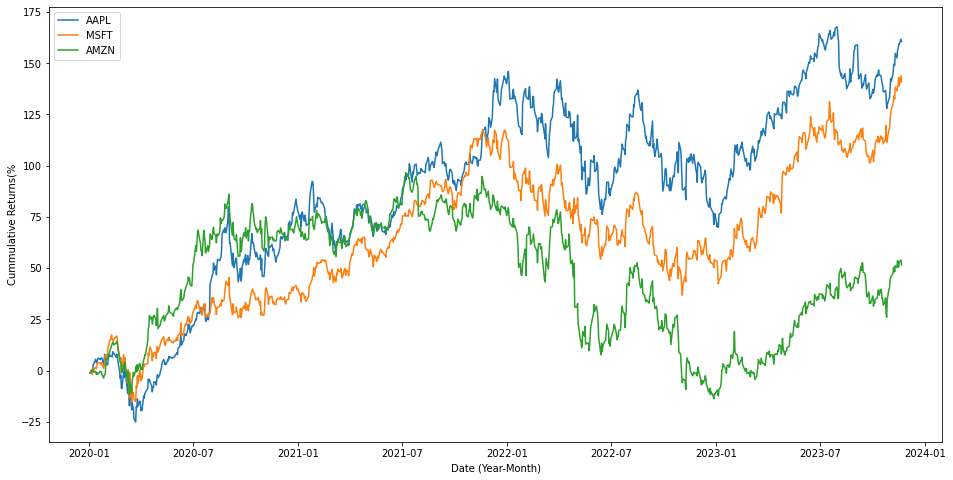

In [125]:
tickers = [
    "AAPL",
    "MSFT",
    "AMZN",
]

START_DATE = "2020-01-01"
END_DATE = "2023-11-22"

tickers_df = load_ticker_prices_ts_df(tickers, START_DATE, END_DATE)
graph_df = tickers_df.dropna(axis=1).pct_change().dropna()  # first % is NaN

# 1+ to allow the cumulative product of returns over time, and -1 to remove it at the end.
graph_df = (1 + graph_df).cumprod() - 1

plt.figure(figsize=(16, 8))
for ticker in graph_df.columns:
    plt.plot(graph_df.index, graph_df[ticker] * 100.0, label=ticker)

plt.xlabel("Date (Year-Month)")
plt.ylabel("Cummulative Returns(%")
plt.legend()
plt.show()

In [126]:
import statistics as stats

TARGET = "AAPL"
MA_WINDOW = 20
ARB_WINDOW = 80
BUY_SIG = 0.01
SELL_SIG = -0.01

signals = []

arb_df = tickers_df.copy()
arb_df[f"ema_{TARGET}"] = arb_df[TARGET].ewm(MA_WINDOW, min_periods=MA_WINDOW).mean()
arb_df[f"ema_d_{TARGET}"] = arb_df[TARGET] - arb_df[f"ema_{TARGET}"]
arb_df[f"ema_d_{TARGET}"].fillna(0, inplace=True)

for ticker in tickers:
    if ticker == TARGET:
        continue

    arb_df[f"ema_{ticker}"] = (
        arb_df[ticker].ewm(MA_WINDOW, min_periods=MA_WINDOW).mean()
    )

    arb_df[f"ema_d_{ticker}"] = arb_df[ticker] - arb_df[f"ema_{ticker}"]
    arb_df[f"ema_d_{ticker}"].fillna(0, inplace=True)

    arb_df[f"{ticker}_corr_{TARGET}"] = (
        arb_df[f"ema_d_{TARGET}"].rolling(ARB_WINDOW).corr(arb_df[f"ema_d_{ticker}"])
    )

    arb_df[f"{ticker}_covr_{TARGET}"] = (
        arb_df[[f"ema_d_{TARGET}", f"ema_d_{ticker}"]]
        .rolling(ARB_WINDOW)
        .cov(min_periods=ARB_WINDOW, numeric_only=True)
        .groupby(level=0, axis=0, dropna=True)  # Cov returns pairwise!
        .apply(lambda x: x.iloc[0, 0] / x.iloc[0, 1])
    )
    arb_df[f"{ticker}_pmv_{TARGET}"] = (
        arb_df[f"ema_d_{ticker}"] * arb_df[f"{ticker}_covr_{TARGET}"]
    )

    arb_df[f"{ticker}_dmv_{TARGET}"] = (
        arb_df[f"{ticker}_pmv_{TARGET}"] - arb_df[f"ema_d_{TARGET}"]
    )

arb_df.tail(5)

,AAPL,MSFT,AMZN,ema_AAPL,ema_d_AAPL,ema_MSFT,ema_d_MSFT,MSFT_corr_AAPL,MSFT_covr_AAPL,MSFT_pmv_AAPL,MSFT_dmv_AAPL,ema_AMZN,ema_d_AMZN,AMZN_corr_AAPL,AMZN_covr_AAPL,AMZN_pmv_AAPL,AMZN_dmv_AAPL
2023-11-15 00:00:00,188.009995,369.670013,143.199997,178.250593,9.759401,341.615408,28.054605,0.646167,0.777233,21.804966,12.045565,134.851978,8.348019,0.300293,3.231891,26.979891,17.220490
2023-11-16 00:00:00,189.710007,376.170013,142.830002,178.796280,10.913727,343.260866,32.909148,0.681524,0.714391,23.510015,12.596289,135.231884,7.598118,0.321656,3.041039,23.106175,12.192448
2023-11-17 00:00:00,189.690002,369.850006,145.179993,179.315029,10.374974,344.527015,25.322991,0.716130,0.676294,17.125778,6.750804,135.705603,9.474390,0.346742,2.838632,26.894308,16.519334
2023-11-20 00:00:00,191.449997,377.440002,146.130005,179.892884,11.557113,346.094300,31.345702,0.746881,0.635385,19.916602,8.359489,136.202003,9.928002,0.363563,2.720540,27.009521,15.452408
2023-11-21 00:00:00,190.639999,373.070007,143.899994,180.404652,10.235348,347.378858,25.691150,0.776254,0.603276,15.498853,5.263505,136.568574,7.331420,0.366093,2.715956,19.911814,9.676467


In [127]:
weights = 0
for ticker in tickers:
    if ticker == TARGET:
        continue
    weights += abs(arb_df[f"{ticker}_corr_{TARGET}"])
weights.tail(1)

2023-11-21    1.142347
Name: MSFT_corr_AAPL, dtype: float64

In [128]:
delta_projected = 0
for ticker in tickers:
    if ticker == TARGET:
        continue
    delta_projected += (
        arb_df[f"{ticker}_corr_{TARGET}"] * arb_df[f"{ticker}_dmv_{TARGET}"]
    )
    arb_df[f"{ticker}_d_prj"] = delta_projected / weights

arb_df.tail(1)

,AAPL,MSFT,AMZN,ema_AAPL,ema_d_AAPL,ema_MSFT,ema_d_MSFT,MSFT_corr_AAPL,MSFT_covr_AAPL,MSFT_pmv_AAPL,MSFT_dmv_AAPL,ema_AMZN,ema_d_AMZN,AMZN_corr_AAPL,AMZN_covr_AAPL,AMZN_pmv_AAPL,AMZN_dmv_AAPL,MSFT_d_prj,AMZN_d_prj
2023-11-21 00:00:00,190.639999,373.070007,143.899994,180.404652,10.235348,347.378858,25.69115,0.776254,0.603276,15.498853,5.263505,136.568574,7.33142,0.366093,2.715956,19.911814,9.676467,3.576686,6.677747


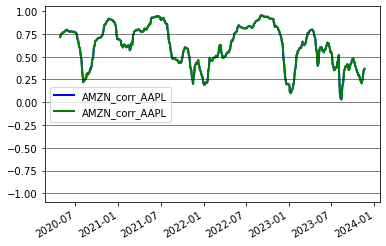

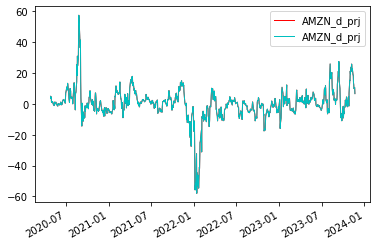

In [130]:
from itertools import cycle

cycol = cycle("bgrcmky")
correlation_data = pd.DataFrame()
for symbol in tickers:
    if symbol == TARGET:
        continue
    correlation_data = correlation_data.assign(
        label=pd.Series(
            arb_df[f"{ticker}_corr_{TARGET}"], index=tickers_df[TARGET].index
        )
    )
    ax = correlation_data["label"].plot(
        color=next(cycol), lw=2.0, label=f"{ticker}_corr_{TARGET}"
    )

for i in np.arange(-1, 1, 0.25):
    plt.axhline(y=i, lw=0.5, color="k")
plt.legend()
plt.show()

# Plot StatArb signal provided by each currency pair
delta_projected_actual_data = pd.DataFrame()
for symbol in tickers:
    if symbol == TARGET:
        continue
    delta_projected_actual_data = delta_projected_actual_data.assign(
        StatArbTradingSignal=pd.Series(
            arb_df[f"{ticker}_d_prj"],
            index=tickers_df[TARGET].index,
        )
    )
    ax = delta_projected_actual_data["StatArbTradingSignal"].plot(
        color=next(cycol), lw=1.0, label=f"{ticker}_d_prj"
    )

plt.legend()
plt.show()

# Conclusion

TODO

![TODO]()

## References

- https://www.nasdaq.com/solutions/nasdaq-100/companies
- 
## Github

Article here is also available on [Github]()

Kaggle notebook available [here]()


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.